In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from functools import reduce
from itertools import cycle

In [3]:
from model_utils.utils_model import Evaluator

In [4]:
import model_utils.utils_s2 as us2 # TODO merge s2 util
from model_utils.utils_nn_s2 import predict_wrapper

In [5]:
# TODO move to util
def stem2db_str(df_stem, seq_len):
    bracket_pairs = cycle([('(', ')'), ('[', ']'), ('{', '}')])
    
    db_str = ['.'] * seq_len
    for _, row in df_stem.iterrows():
        bb_x = int(row['bb_x'])
        bb_y = int(row['bb_y'])
        siz = int(row['siz_x'])
        siz_y = int(row['siz_y'])
        assert siz == siz_y
        bracket_pair = next(bracket_pairs)  # py3
        for i in range(siz):
            db_str[bb_x+i] = bracket_pair[0]
            db_str[bb_y-i] = bracket_pair[1]
    return ''.join(db_str)

In [22]:
def display_ss_graph(df_stem, seq):
    G = nx.Graph()
    nodes = []
    for i, base in enumerate(seq):
        nodes.append((i, {"label": base}))
    G.add_nodes_from(nodes)
    # backbone
    for i in range(len(seq)-1):
        G.add_edge(i, i+1)
    # hydrogen bonds
    for _, row in df_stem.iterrows():
        bb_x = int(row['bb_x'])
        bb_y = int(row['bb_y'])
        siz = int(row['siz_x'])
        siz_y = int(row['siz_y'])
        assert siz == siz_y
        for i in range(siz):
            G.add_edge(bb_x+i,bb_y-i)
    return G
#     G.add_edge(1,2)
#     G.add_edge(1,3)
#     nx.draw(G, with_labels=True)
#     plt.show()

In [6]:
predictor_s2 = us2.Predictor('v0.2')

Loading S2 model v0.2 with params: in_size 11, d_model 100, N 6, heads 5, n_hid 20


In [7]:
df = pd.read_pickle('../2021_01_12/data/synthetic_s1_pred_1000_t0p1_k1.pkl.gz')

In [8]:
evaluator = Evaluator(predictor=None)   # using static utils

Initializing evaluator without predictor


In [9]:
# row = df.iloc[0]   # plot fixed


# row = df.iloc[1]


row = df.iloc[2]
row

ensemble_diversity                                                  0.6
free_energy                                                        -2.7
len                                                                  17
mfe_frequency                                                  0.759655
one_idx               ([3, 4, 5, 6, 11, 12, 13, 14], [14, 13, 12, 11...
seq                                                   CGUAUCCGCCCGGAUUA
bounding_boxes        [((3, 11), (4, 4), stem), ((6, 6), (6, 6), hai...
bb_stem               [{'bb_x': 3, 'bb_y': 14, 'siz_x': 4, 'siz_y': ...
bb_iloop                                                           None
bb_hloop              [{'bb_x': 6, 'bb_y': 11, 'siz_x': 6, 'siz_y': ...
Name: 488437, dtype: object

In [10]:
seq = row['seq']
uniq_stem = pd.DataFrame(row['bb_stem'])
uniq_iloop = pd.DataFrame(row['bb_iloop'])
uniq_hloop = pd.DataFrame(row['bb_hloop'])
df_pred = predict_wrapper(uniq_stem, uniq_iloop, uniq_hloop, discard_ns_stem=True, min_hloop_size=2, seq=seq, m_factor=1, predictor=predictor_s2)

df_stem base pair pruning, before: 1, after: 1
df_hloop min size pruning, before: 1, after: 1


In [11]:
df_pred

,bb_x,bb_y,siz_x,siz_y,pred,id_bb,bb_type
0,3.0,14.0,4.0,4.0,0.999083,stem_0,stem
1,6.0,11.0,6.0,6.0,0.998932,hloop_0,hloop


In [12]:
df_target_stem, df_target_iloop, df_target_hloop = evaluator.make_target_bb_df(row['bounding_boxes'], convert_tl_to_tr=True)

In [13]:
df_target_stem

,bb_x,bb_y,siz_x,siz_y
0,3,14,4,4


In [14]:
df_target_iloop

[]

In [15]:
df_target_hloop

,bb_x,bb_y,siz_x,siz_y
0,6,11,6,6


In [16]:
print(seq)
db_str_target = stem2db_str(df_target_stem, len(seq))
print(db_str_target)

CGUAUCCGCCCGGAUUA
...((((....))))..


In [17]:
print(seq)
db_str_pred = stem2db_str(df_pred[df_pred['bb_type'] == 'stem'], len(seq))
print(db_str_pred)
# # debug
# df_tmp = pd.DataFrame({'idx_0': range(len(seq)), 'idx_1': range(1, len(seq)+1),
#                       'base': list(seq), 'db_char': list(db_str_pred)})
# df_tmp

CGUAUCCGCCCGGAUUA
...((((....))))..


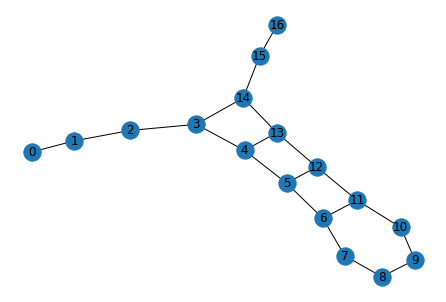

In [23]:
G = display_ss_graph(df_pred[df_pred['bb_type'] == 'stem'], seq)
nx.draw(G, with_labels=True)
#     plt.show()